<a href="https://colab.research.google.com/github/GabrielVogel/Implementa-es/blob/master/Rede_neural_usando_apenas_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_der(z):
    return (1 - sigmoid(z)) * sigmoid(z)

def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

def CategoricalCrossEntropy(y,y_pred):
    return -np.sum(y * np.log(y_pred))

def relu(Z):

  return np.maximum(Z,0)

def der_relu(x):
  x[x<=0] = 0
  x[x>0] = 1
  return x

In [3]:
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
(X_train, y_train), (X_test, y_test)= mnist.load_data()

In [0]:
X_train = X_train.reshape(X_train.shape[0],28 * 28)
Ytrain = np.zeros((60000, 10))
for i in range(60000):
    Ytrain[i][y_train[i]]= 1
Ytest= np.zeros((10000, 10))
for i in range(10000):
    Ytest[i][y_test[i]]= 1

In [0]:
D = 784
K = Ytrain.shape[1]
n = 1000

In [0]:
def forward_pass(X,W,b):
    
    Z = np.dot(X,W) + b
    return relu(Z),Z

def ForwardPropagation(X,params):
    
    L = len(params) // 2
    Ao = X
    Zs = []
    Als = [Ao]
    for l in range(1,L):
        Al, Zl = forward_pass(Ao,params["W"+str(l)],params["b"+str(l)])
        Zs.append(Zl)
        Als.append(Al)
        Ao = Al
    ZL = np.dot(Ao, params["W"+str(L)]) + params["b"+str(L)]
    Zs.append(ZL)
    AL = softmax(ZL)
    return AL,Zs,Als
        

In [0]:
def LastLayerBackward(y, y_hat,W,Al_1):
    dL_dz2 = y_hat - y
    db = dL_dz2.sum(axis = 0) * 1/ n
    dW = np.dot(Al_1.T,dL_dz2) * 1/n
    dAl_1 = np.dot(dL_dz2,W.T)
    
    return dW,db,dAl_1
    

In [0]:
def OtherLayerBackwards(dAl,Z,W,Al_1):
    dL_dz = dAl * der_relu(Z)
    db = dL_dz.sum(axis = 0) * 1/ n
    dW = np.dot(Al_1.T,dL_dz) * 1/n
    dAl_1 = np.dot(dL_dz,W.T)
    
    return dW,db,dAl_1

In [0]:
def Regularization(lambd, params,m):

  L = len(params) // 2
  s = 0
  for l in range(1,L+1):
    s += np.sum(params["W"+str(l)] ** 2)

  return 1/m * lambd / 2 * s

In [0]:
def train(X,Y,X_train,Y_train,params,learning_rate,epochs,lambd,beta):
    
    L = len(params) // 2
    losses = []
    test_losses = []
    m = Y.shape[0]
    for epoch in range(epochs):
        pred, Zs,Als = ForwardPropagation(X,params)
        regularization = Regularization(lambd, params,pred.shape[0])
        l = CategoricalCrossEntropy(Y,pred)
        
        pred_test,_,_ = ForwardPropagation(X_train,params)
        loss_test = CategoricalCrossEntropy(Y_train,pred_test)
        test_losses.append(loss_test)        
        
        cost = l + regularization
        losses.append(cost)
        if epoch % 200 == 0:
          print(f"Epoch {epoch} : {l}")
        
        dW,db,dAl_1 = LastLayerBackward(Y,pred,params["W"+str(L)],Als[-1])
        v = {}
        for l in range(L):
          v["dW" + str(l+1)] = np.zeros_like(params['W' + str(l+1)])
          v["db" + str(l+1)] = np.zeros_like(params['b' + str(l+1)])
        
        v["dW" + str(L)] = beta * v["dW" + str(L)] + (1-beta) * dW
        v["db" + str(L)] = beta * v["db" + str(L)] + (1-beta) * db
        
        
        
        
        params["W"+str(L)] -= learning_rate * v["dW"+str(L)] + params["W"+str(L)] * (lambd / m)
        params["b"+str(L)] -= learning_rate * v["db"+str(L)]
        
        for l in reversed(range(L-1)):
            dw,db,dAl_1 = OtherLayerBackwards(dAl_1,Zs[l],params["W"+str(l+1)],Als[l])
            
            ##updating velocity
            v["dW" + str(l+1)] = beta * v["dW" + str(l+1)] + (1-beta) * dw
            v["db" + str(l+1)] = beta * v["db" + str(l+1)] + (1-beta) * db
            
            params["W"+str(l+1)] -= learning_rate * v["dW"+str(l+1)] + params["W"+str(l+1)] * (lambd / m)
            params["b"+str(l+1)] -= learning_rate * v["db"+str(l+1)]
    
          
    return losses,test_losses

In [0]:
def fit(X,y,X_train,Y_train,Dims,epochs,learning_rate,lambd,beta):

    params = {}
    ##Using He initializatiom
    for i in range(len(Dims)-1):
        params["W"+str(i+1)] = np.random.randn(Dims[i],Dims[i+1]) * np.sqrt(1 / Dims[i])
        params["b"+str(i+1)] = np.zeros(Dims[i+1])  
        
    
    losses,test_losses = train(X,y,X_train,Y_train,params,learning_rate,epochs,lambd,beta)
    
    plt.plot(losses, label = 'Train losses')
    plt.plot(test_losses,label = 'Test losses')
    plt.legend()
    return losses,params

In [0]:
def PlotCurve(losses):
    plt.plot(losses)

Epoch 0 : 151088.6804320167
Epoch 200 : 49.88670487421881
Epoch 400 : 10.95833285574725
Epoch 600 : 9.224223729354662
Epoch 800 : 9.435328759731586


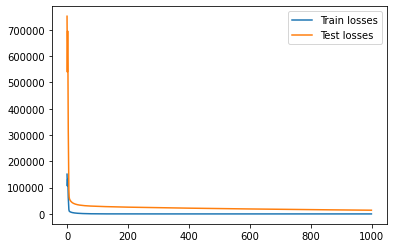

In [41]:
dims = [D,128,K]
n = 2000
losses,params = fit(X_train[:n],Ytrain[:n],X_test.reshape(10000,784),Ytest,dims, epochs = 1000,learning_rate=10e-3,lambd =0.7,beta=0.9)

In [42]:
losses[-1]

10.240865681215247

In [0]:
AL,_,_ = ForwardPropagation(X_test.reshape(10000,784),params)

In [0]:
total = Ytest.shape[0]
counts = 0
for i,x in enumerate(softmax(AL)):
  if x.argmax() == Ytest[i].argmax():
    counts += 1

In [45]:
accuracy_test = counts / total
print(f"Accuracy test:{accuracy_test*100} %")

Accuracy test:81.88 %


In [46]:
total = Ytrain.shape[0]
counts = 0
AL,_,_ = ForwardPropagation(X_train,params)

for i, x in enumerate(softmax(AL)):

  if x.argmax() == Ytrain[i].argmax():
    counts += 1
accuracy_train = counts / total
print(f"Accuracy train:{accuracy_train*100} %")

Accuracy train:81.15333333333334 %
